In [3]:
import os
import pandas as pd
print(os.getcwd())

try:
    os.chdir("../../workshop_02")

except FileNotFoundError:
    print("Directory not found or already exists.")
    
print(os.getcwd())

/home/edwards/Documentos/university/etl/workshop_02/notebooks
/home/edwards/Documentos/university/etl/workshop_02


In [4]:
from database.db_connection import get_connection

In [5]:
conn = get_connection()
cursor = conn.cursor()

In [ ]:
import logging
import psycopg2


try:
    conn = get_connection()
    print("Conexión creada con éxito")
    if conn.closed:
        print("ERROR: La conexión está cerrada inmediatamente después de crearla")
        raise Exception("Conexión cerrada inesperadamente")
    print("La conexión está abierta")
    cursor = conn.cursor()
    print("Cursor creado con éxito")
    cursor.execute("SELECT current_database();")
    db_name = cursor.fetchone()[0]
    print(f"Base de datos actual: {db_name}")
    logging.info("Conexión a la base de datos establecida con éxito")
    print("Conexión establecida a 'spotify' en puerto 5433")
except Exception as e:
    logging.error(f"Error al conectar a la base de datos: {e}")
    print(f"Error al conectar: {e}")
    raise

try:
    df = pd.read_csv('data/the_grammy_awards.csv')
    logging.info(f"CSV cargado con éxito: {df.shape[0]} filas y {df.shape[1]} columnas")
    print(f"CSV cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError as e:
    logging.error(f"Error: No se encontró el archivo CSV en 'data/the_grammy_awards.csv': {e}")
    raise
except Exception as e:
    logging.error(f"Error al leer el CSV: {e}")
    raise

try:
    # Crear el esquema 'grammys' si no existe
    cursor.execute("""
        CREATE SCHEMA IF NOT EXISTS grammys;
    """)
    logging.info("Esquema 'grammys' creado con éxito")
    print("Esquema 'grammys' creado")

    # Crear la tabla 'grammy_awards' dentro del esquema 'grammys'
    cursor.execute("""
        DROP TABLE IF EXISTS grammys.grammy_awards;
        CREATE TABLE grammys.grammy_awards (
            id SERIAL PRIMARY KEY,
            year INTEGER,
            title TEXT,
            published_at TIMESTAMP,
            updated_at TIMESTAMP,
            category TEXT,
            nominee TEXT,
            artist TEXT,
            workers TEXT,
            img TEXT,
            winner BOOLEAN
        )
    """)
    logging.info("Tabla 'grammys.grammy_awards' creada con éxito")
    print("Tabla 'grammys.grammy_awards' creada")
except Exception as e:
    logging.error(f"Error al crear el esquema o la tabla: {e}")
    conn.rollback()
    raise

try:
    row_count = 0
    for index, row in df.iterrows():
        cursor.execute("""
            INSERT INTO grammys.grammy_awards (
                year, title, published_at, updated_at, category, 
                nominee, artist, workers, img, winner
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, (
            row['year'], row['title'], row['published_at'], row['updated_at'],
            row['category'], row['nominee'], row['artist'], row['workers'],
            row['img'], row['winner']
        ))
        row_count += 1
    conn.commit()
    logging.info(f"Datos insertados con éxito en grammys.grammy_awards: {row_count} registros")
    print(f"Datos insertados en grammys.grammy_awards: {row_count} registros")
except Exception as e:
    logging.error(f"Error al insertar datos: {e}")
    conn.rollback()
    raise

finally:
    try:
        cursor.close()
        conn.close()
        logging.info("Conexión y cursor cerrados con éxito")
        print("Conexión cerrada")
    except Exception as e:
        logging.error(f"Error al cerrar la conexión: {e}")
        print(f"Error al cerrar: {e}")

print("Proceso completado")

Nueva conexión creada
Conexión creada con éxito
La conexión está abierta
Cursor creado con éxito
Base de datos actual: spotify
Conexión establecida a 'spotify' en puerto 5433
CSV cargado: 4810 filas, 10 columnas
Esquema 'grammys' creado
Tabla 'grammys.grammy_awards' creada
Datos insertados en grammys.grammy_awards: 4810 registros
Conexión cerrada
Proceso completado


In [7]:
from sqlalchemy import create_engine, inspect, text
from dotenv import load_dotenv

load_dotenv('env/.env')

True

In [8]:
engine = create_engine(
    f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@"
    f"{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
)

In [17]:
sample_data = pd.read_sql("SELECT * FROM grammys.grammy_awards LIMIT 5", engine)
sample_data

,id,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,5,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


In [18]:
year_dist = pd.read_sql("""
    SELECT year, 
           COUNT(*) as nominaciones, 
           SUM(CASE WHEN winner THEN 1 ELSE 0 END) as premios
    FROM grammys.grammy_awards 
    GROUP BY year 
    ORDER BY year
""", engine)

display(year_dist)

,year,nominaciones,premios
0,1958,28,28
1,1959,35,35
2,1960,39,39
3,1961,41,41
4,1962,39,39
...,...,...,...
57,2015,84,84
58,2016,85,85
59,2017,86,86
60,2018,86,86


In [19]:
top_categories = pd.read_sql("""
    SELECT category, 
           COUNT(*) as total_nominaciones,
           ROUND(100.0 * SUM(CASE WHEN winner THEN 1 ELSE 0 END) / COUNT(*), 2) as porcentaje_ganadores
    FROM grammys.grammy_awards 
    GROUP BY category 
    ORDER BY total_nominaciones DESC 
    LIMIT 10
""", engine)

display(top_categories)

,category,total_nominaciones,porcentaje_ganadores
0,Song Of The Year,70,100.0
1,Record Of The Year,69,100.0
2,Album Of The Year,66,100.0
3,Best Opera Recording,64,100.0
4,Best Album Notes,63,100.0
5,Best Instrumental Composition,55,100.0
6,Best Country Song,55,100.0
7,Best New Artist,51,100.0
8,Best Historical Album,44,100.0
9,Best Chamber Music Performance,43,100.0


In [14]:
top_artists = pd.read_sql("""
    SELECT artist, 
           COUNT(*) as nominaciones,
           SUM(CASE WHEN winner THEN 1 ELSE 0 END) as premios
    FROM grammys.grammy_awards
    WHERE artist IS NOT NULL
    GROUP BY artist 
    ORDER BY nominaciones DESC 
    LIMIT 10
""", engine)

print("\nTop 10 artistas con más nominaciones:")
display(top_artists)


Top 10 artistas con más nominaciones:


,artist,nominaciones,premios
0,NaN,1840,1840
1,(Various Artists),66,66
2,U2,18,18
3,Aretha Franklin,16,16
4,Ella Fitzgerald,13,13
5,Bruce Springsteen,13,13
6,Beyoncé,13,13
7,Stevie Wonder,13,13
8,Jimmy Sturr,12,12
9,Dixie Chicks,12,12


Eliminamos los valores nulos porque son demasiados valores como para intentar imputar valores a partir del nomidado

In [61]:

with engine.begin() as conn:
    conn.execute(text("""
        DELETE FROM grammys.grammy_awards
        WHERE artist = 'NaN'
    """))

In [15]:
null_analysis = pd.read_sql("""
    SELECT 
        COUNT(*) - COUNT(artist) as artist_null,
        COUNT(*) - COUNT(workers) as workers_null,
        COUNT(*) - COUNT(img) as img_null
    FROM grammys.grammy_awards
""", engine)

print("\nAnálisis de valores nulos:")
display(null_analysis)


Análisis de valores nulos:


,artist_null,workers_null,img_null
0,0,0,0


In [ ]:
with engine.connect() as conn:
    # Obtener tipos de datos
    column_types = pd.read_sql("""
        SELECT column_name, data_type 
        FROM information_schema.columns 
        WHERE table_schema = 'grammys' AND table_name = 'grammy_awards'
    """, conn)
    
    print("\nTipos de datos por columna:")
    display(column_types)
    unique_counts = []
    for column in column_types['column_name']:
        if column != 'id':
            result = conn.execute(text(f"""
                SELECT COUNT(DISTINCT {column}) as unique_count 
                FROM grammys.grammy_awards
            """)).fetchone()
            unique_counts.append({'columna': column, 'valores_unicos': result[0]})
    
unique_df = pd.DataFrame(unique_counts)
(unique_df)


Tipos de datos por columna:


,column_name,data_type
0,id,integer
1,year,integer
2,title,text
3,category,text
4,nominee,text
5,artist,text



Conteo de valores únicos por columna:


,columna,valores_unicos
0,year,62
1,title,62
2,category,638
3,nominee,4132
4,artist,1659


In [33]:

with engine.begin() as conn:
    conn.execute(text("""
        ALTER TABLE grammys.grammy_awards
        DROP COLUMN IF EXISTS winner,
        DROP COLUMN IF EXISTS workers,
        DROP COLUMN IF EXISTS img,
        DROP COLUMN IF EXISTS published_at,
        DROP COLUMN IF EXISTS title
    """))

In [34]:
with engine.connect() as conn:
    updated_columns = pd.read_sql("""
        SELECT column_name, data_type 
        FROM information_schema.columns 
        WHERE table_schema = 'grammys' AND table_name = 'grammy_awards'
    """, conn)
    
updated_columns

,column_name,data_type
0,id,integer
1,year,integer
2,category,text
3,nominee,text
4,artist,text


In [38]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT DISTINCT year FROM grammys.grammy_awards ORDER BY year"))
    years = [row[0] for row in result]
    print("Valores únicos en 'year':")
    print(years)

Valores únicos en 'year':
[1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [39]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT DISTINCT category FROM grammys.grammy_awards ORDER BY category"))
    categories = [row[0] for row in result]
    print("Valores únicos en 'category':")
    print(categories)

Valores únicos en 'category':
['Album Of Best Original Score Written For A Motion Picture Or A Television Special', 'Album Of Best Original Score Written For A Motion Picture Or Television Special', 'Album Of The Year', 'Album Of The Year - Classical', 'Album Of The Year -- Classical', 'Album Of The Year, Classical', 'Album Of The Year (Other Than Classical)', 'Best Accompaniment Arrangement For Vocalist(s) Or Instrumentalist(s)', 'Best Album Cover', 'Best Album Cover - Classical', 'Best Album Cover - Graphic Arts', 'Best Album Cover - Other Than Classical', 'Best Album Cover - Photography', 'Best Album Cover, Graphic Arts', 'Best Album Cover (Other Than Classical)', 'Best Album Cover- Other Than Classical', 'Best Album Cover, Photography', 'Best Album Created For Children', 'Best Album For Children', 'Best Album Notes', 'Best Album Notes - Classical', 'Best Album Notes (Classical)', 'Best Album Notes, Classical', 'Best Album Of Original Instrumental Background Score Written For A Moti

Hay demasiadas categorias y a nosotros solo nos importan las canciones, podcast y probablemente los albumes, por ahora la usaremos para hacer un eda sencillo pero luego las voy a eliminar las categorias que no tengan que ver con sonidos, albumes y nada

In [41]:
import matplotlib.pyplot as plt

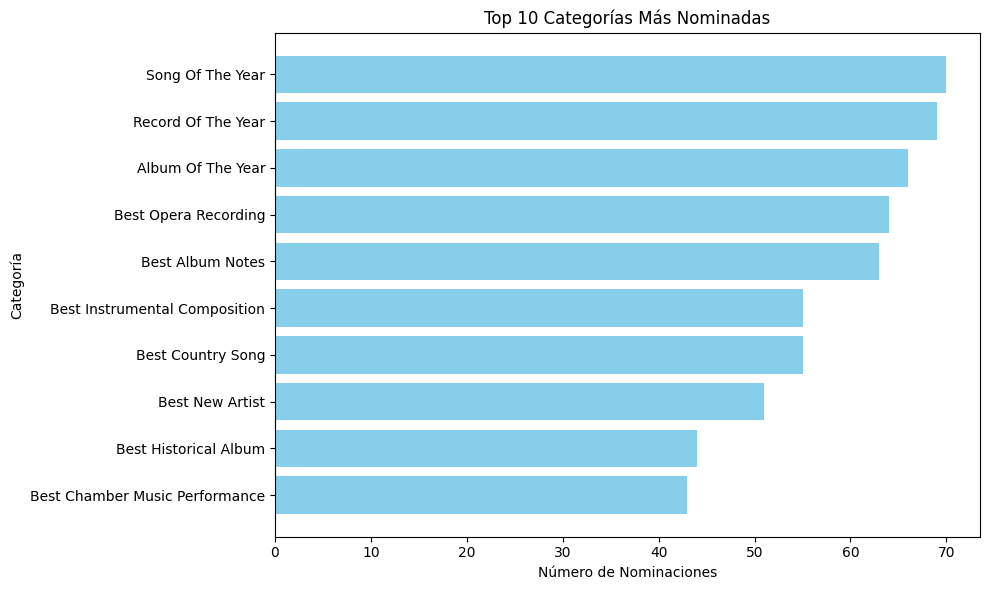

In [42]:
with engine.connect() as conn:
    df = pd.read_sql(text("""
        SELECT category, COUNT(*) as nomination_count
        FROM grammys.grammy_awards
        GROUP BY category
        ORDER BY nomination_count DESC
        LIMIT 10
    """), conn)

plt.figure(figsize=(10, 6))
plt.barh(df['category'], df['nomination_count'], color='skyblue')
plt.xlabel('Número de Nominaciones')
plt.ylabel('Categoría')
plt.title('Top 10 Categorías Más Nominadas')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
with engine.connect() as conn:
    result = conn.execute(text("""
        SELECT 
            SUM(CASE WHEN year IS NULL THEN 1 ELSE 0 END) as year_nulls,
            SUM(CASE WHEN category IS NULL THEN 1 ELSE 0 END) as category_nulls,
            SUM(CASE WHEN nominee IS NULL THEN 1 ELSE 0 END) as nominee_nulls,
            SUM(CASE WHEN artist IS NULL THEN 1 ELSE 0 END) as artist_nulls
        FROM grammys.grammy_awards
    """))
    null_counts = result.fetchone()
    print("Valores nulos por columna:")
    print(f"year: {null_counts[0]}")
    print(f"category: {null_counts[1]}")
    print(f"nominee: {null_counts[2]}")
    print(f"artist: {null_counts[3]}")

Valores nulos por columna:
year: 0
category: 0
nominee: 0
artist: 0


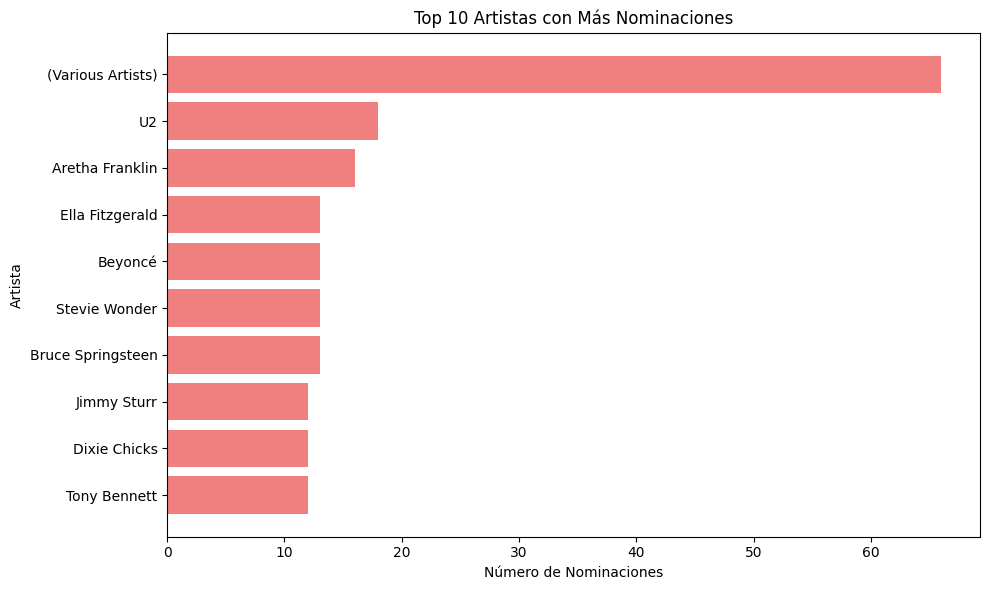

In [62]:
with engine.connect() as conn:
    df = pd.read_sql(text("""
        SELECT artist, COUNT(*) as nomination_count
        FROM grammys.grammy_awards
        WHERE artist IS NOT NULL
        GROUP BY artist
        ORDER BY nomination_count DESC
        LIMIT 10
    """), conn)

plt.figure(figsize=(10, 6))
plt.barh(df['artist'], df['nomination_count'], color='lightcoral')
plt.xlabel('Número de Nominaciones')
plt.ylabel('Artista')
plt.title('Top 10 Artistas con Más Nominaciones')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

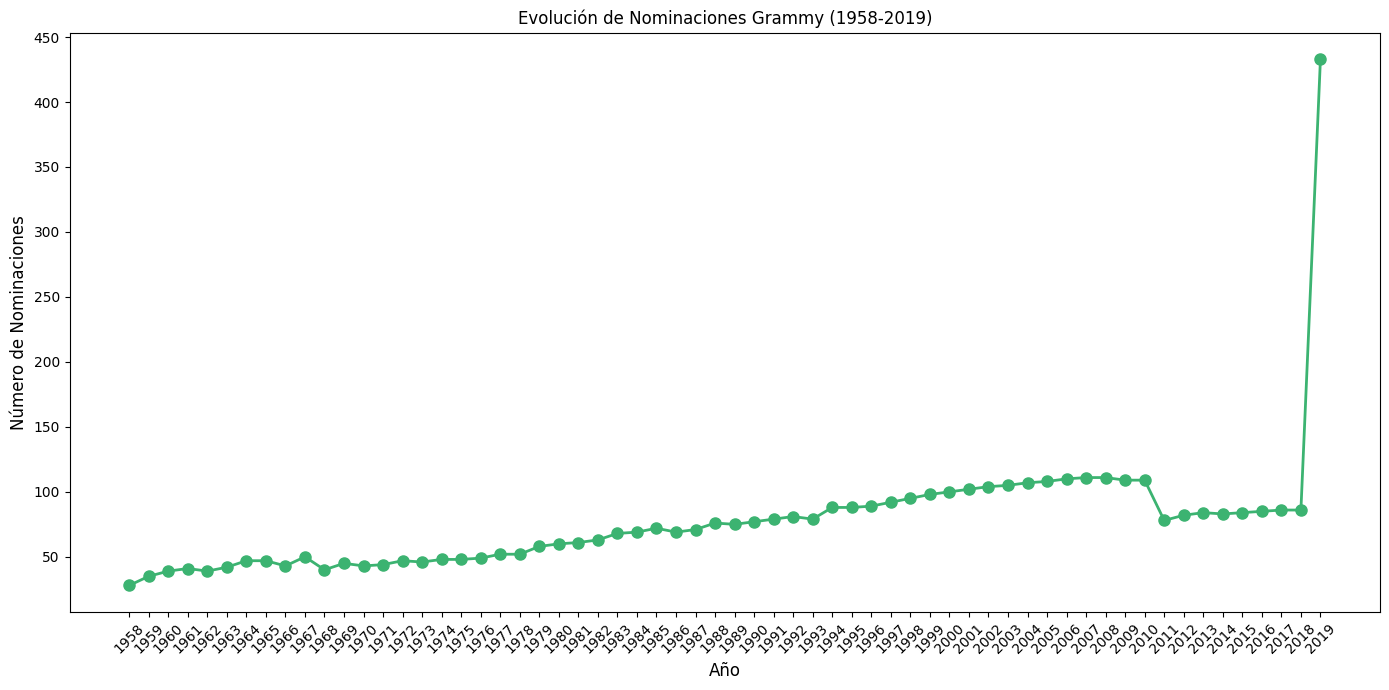

In [ ]:
# Bloque 17: Gráfico de líneas de nominaciones por año (1958-2019)
import matplotlib.pyplot as plt

with engine.connect() as conn:
    df = pd.read_sql(text("""
        SELECT year, COUNT(*) as nomination_count
        FROM grammys.grammy_awards
        WHERE year BETWEEN 1958 AND 2019
        GROUP BY year
        ORDER BY year ASC
    """), conn)

plt.figure(figsize=(14, 7))
plt.plot(df['year'], df['nomination_count'], 
         marker='o', 
         linestyle='-', 
         color='mediumseagreen',
         linewidth=2,
         markersize=8)

plt.xlabel('Año', fontsize=12)
plt.ylabel('Nomination number', fontsize=12)
plt.title('Evolution Grammy (1958-2019)')

plt.xticks(range(1958, 2020), rotation=45)

plt.tight_layout()
plt.show()

In [64]:
with engine.connect() as conn:
    df = pd.read_sql(text("SELECT * FROM grammys.grammy_awards"), conn)

# Guardar el DataFrame como CSV
df.to_csv('data/grammys.csv', index=False)
print("Tabla completa guardada en 'data/grammys.csv'")

Tabla completa guardada en 'data/grammys.csv'


In [70]:
df = pd.read_csv('data/grammys.csv')

text_columns = ['category', 'nominee', 'artist']

for col in text_columns:
    df[col] = df[col].str.lower().str.strip()

df.to_csv('data/grammys.csv', index=False)
print("Datos de texto normalizados y guardados en 'data/grammys.csv'")

Datos de texto normalizados y guardados en 'data/grammys.csv'
